In [11]:
import numpy as np
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, interactive
import ipywidgets as widgets
import time
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family'] = ['WenQuanYi Zen Hei']
plt.rcParams['font.serif'] = ['WenQuanYi Zen Hei']
# matplotlib.rcParams['font.serif'] = ['WenQuanYi Zen Hei']


A = {up,down,right,left}

P(a=u)=P(a=d)=P(a=r)=P(a=l)=0.25

In [12]:
# R_u=-np.ones((16,1))
# R_d=-np.ones((16,1))
# R_r=-np.ones((16,1))
# R_l=-np.ones((16,1))
# 收益
R_s=-np.ones((16,1))
R_s[0]=0


P.shape=(16,16)
下面对应P的行列

 1 2 3 4
 
 5 6 7 8
 
 9 10 11 12
 
 13 14 15 16
 

In [13]:
gamma=1
row_num=4
col_num=4
s_num=col_num*row_num

## 下面是P(a|s)，因为
idx_map=np.arange(0,16).reshape((4,4))
## a=up
P_u=np.zeros((16,16))
for col in range(col_num):
    P_u[col,col]=1
    for row in range(1,row_num):
        s=idx_map[row,col]
        s_next=idx_map[row-1,col]
        P_u[s,s_next]=1
## a=down
P_d=np.zeros((16,16))
for col in range(col_num):
    P_d[s_num-col-1,s_num-col-1]=1
    for row in range(0,row_num-1):
        s=idx_map[row,col]
        s_next=idx_map[row+1,col]
        P_d[s,s_next]=1
# 吸收态 S0终止，无法向右
P_d[0,0]=1;P_d[0,col_num]=0

## a=right
P_r=np.zeros((16,16))
for row in range(row_num):
    offset=idx_map[row,0] # 第[row,0]对应第几个s
    P_r[offset+col_num-1,offset+col_num-1]=1
    for col in range(0,col_num-1):
        P_r[offset+col,offset+col+1]=1
# 吸收态 S0终止，无法向右
P_r[0,0]=1;P_r[0,1]=0

## a=left
P_l=np.zeros((16,16))
for row in range(row_num):
    offset=idx_map[row,0]
    P_l[offset,offset]=1
    for col in range(1,col_num):
        P_l[offset+col,offset+col-1]=1


In [14]:
#转为稀疏矩阵 运算变慢

# sp_d=sparse.csr_matrix(P_d)
# sp_u=sparse.csr_matrix(P_u)
# sp_r=sparse.csr_matrix(P_r)
# sp_l=sparse.csr_matrix(P_l)

In [15]:
v=np.zeros((s_num,1))
v_new=np.ones((s_num,1))
eps=1e-6
iter_num=100
for k in range(iter_num):
    v_d=R_s+gamma*P_d@v
    v_u=R_s+gamma*P_u@v
    v_r=R_s+gamma*P_r@v
    v_l=R_s+gamma*P_l@v
    v_new=np.max([v_d,v_u,v_r,v_l],axis=0)
    if np.all(np.abs(v-v_new)<eps):
        break
    else:
        v=v_new

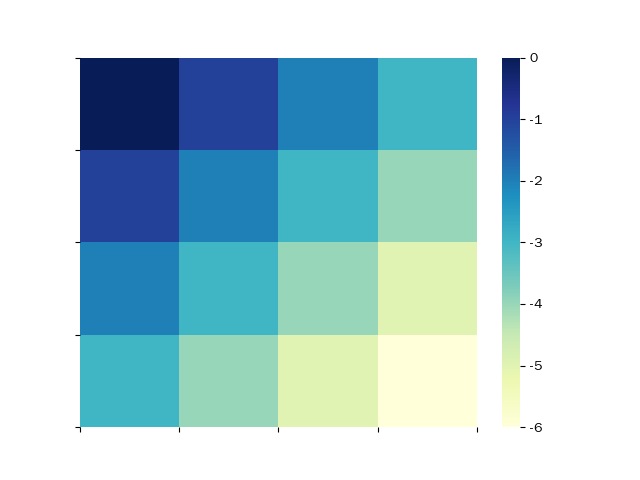

In [16]:
v_new.reshape((4,4))
fig=plt.figure()
ax = fig.add_subplot()
fig = sns.heatmap(v_new.reshape((4,4)), cmap="YlGnBu", ax=ax)
# 定义标签与标题
fig.set_yticks(list(reversed(range(5))))
fig.set_xticks(list(reversed(range(5))))

## 杰克还车
$$
\begin{align}
v(s)=&E_{\pi}[q(s,a)|S_t=s]\\
=&\sum_{a\in A}\pi(a|s)q(s,a)
\end{align}
$$
$\sum_{s',r}p(s',r|s,\pi(s))[r+\gamma v_{\pi}(s')]$


设随机变量$N$表示车厂第二天车辆数
$$
\begin{align}
R(N)=s\times [1-\sum_{k=0}^{s}P_{\lambda_1}(k)]+\sum_{k=0}^s k\times P(\lambda_{1})\\
Ru=s\times [1-\sum_{k=0}^{s}P_{\lambda_1}(k)]\\
Rg=\sum_{k=0}^s k\times P_{\lambda_{1}}(k)\\
\end{align}
$$

In [17]:
# 租出去
lam_b1=3
lam_b2=4
# 收回
lam_r1=3
lam_r2=2

prob_b1=np.array([stats.poisson.pmf(k,lam_b1) for k in range(21)])
prob_b1_cum=1-np.cumsum(prob_b1)

#
Ru=np.arange(21)*prob_b1_cum
Rg=np.cumsum(np.arange(21)*prob_b1)
R_b1=10*(Ru+Rg)

prob_b2=np.array([stats.poisson.pmf(k,lam_b2) for k in range(21)])
prob_b2_cum=1-np.cumsum(prob_b2)
Ru=np.arange(21)*prob_b2_cum
Rg=np.cumsum(np.arange(21)*prob_b2)
R_b2=10*(Ru+Rg)

#### ----------------- ####
## Ps1[i,j]车库1从库存i到库存j的概率
## P(s[0]=i,s'[0]=i+k)=P(s[0]=i-1,s'[0]=i+k-1)+P_lam1(i)*P_sig1(i+k)
tmp=np.zeros((21,21))
Ps1=np.zeros((21,21)) ## s=(i,),s'=(j,),Pss[i,j]=P(s[0]->s'[0])
Ps2=np.zeros((21,21))

prob_r1=np.array([stats.poisson.pmf(k,lam_r1) for k in range(21)])
prob_r2=np.array([stats.poisson.pmf(k,lam_r2) for k in range(21)])

prob_r1_cum=1-np.cumsum(prob_r1)
prob_r2_cum=1-np.cumsum(prob_r2)
inverse_prob_b1_cum=prob_b1_cum[::-1]
inverse_prob_b2_cum=prob_b2_cum[::-1]
inverse_prob_r1_cum=prob_r1_cum[::-1]
inverse_prob_r2_cum=prob_r2_cum[::-1]

## ver2
Ps1[:,0]=prob_b1*prob_r1[0]
Ps1[-1,0]=0# Ps1[0-1,1-1]用到了，要是0，后面再赋值
for s in range(0,Ps1.shape[0]):
    for k in range(1,Ps1.shape[1]):
        Ps1[s,k]=Ps1[s-1,k-1]+prob_b1[s]*prob_r1[k] # 还缺 借车>s,还车=k
    Ps1[s,-1]=Ps1[s,-1]+prob_b1_cum[s]*prob_r1_cum[k]+prob_b1[:(s+1)]@inverse_prob_r1_cum[s::-1] # 还缺 借车>s,还车>20
mat1=prob_b1_cum.reshape((-1,1));mat2=prob_r1.reshape((-1,1))
# mat2[-1]=prob_r1_cum[-1]
Ps1[-1,0]=prob_b1[-1]*prob_r1[0]
Ps1=Ps1+mat1@mat2.T

Ps2[:,0]=prob_b2*prob_r2[0]
Ps2[-1,0]=0# Ps2[0-1,1-1]用到了，要是0，后面再赋值
for s in range(0,Ps2.shape[0]):
    for k in range(1,Ps2.shape[1]):
        Ps2[s,k]=Ps2[s-1,k-1]+prob_b2[s]*prob_r2[k] # 还缺 借车>s,还车=k
    Ps2[s,-1]=Ps2[s,-1]+prob_b2_cum[s]*prob_r2_cum[k]+prob_b2[:(s+1)]@inverse_prob_r2_cum[s::-1] # 还缺 借车>s,还车>20
mat1=prob_b2_cum.reshape((-1,1));mat2=prob_r2.reshape((-1,1))
# mat2[-1]=prob_r1_cum[-1]
Ps2[-1,0]=prob_b2[-1]*prob_r2[0]
Ps2=Ps2+mat1@mat2.T


### policy iteration

In [ ]:
threshold=1e-4
gamma=0.9
v=np.zeros((21,21)) # 车库1×车库2
v_new=np.zeros((21,21))
policy=np.zeros((21,21),dtype=np.int32) # s=(),a=pi(s)

policy_stable=False
iter_num=0

_, axes = plt.subplots(2, 3,figsize=(8, 4))
# 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
# plt.subplots_adjust(wspace=0.1, hspace=0.2)
# 这里将子图形成一个1*6的列表
axes = axes.flatten()
start=time.time()
while not policy_stable:
    print(f"iter_num: {iter_num}")
    while True:
        ## 策略评估
        for car1 in range(21):
            for car2 in range(21):
                s1=car1-policy[car1,car2]
                s2=car2+policy[car1,car2]
                p_snew=Ps1[s1,:].reshape((-1,1))@Ps2[s2,:].reshape((1,-1))
                v_new[car1,car2]=-2*np.abs(policy[car1,car2])+R_b1[s1]+R_b2[s2]+gamma*np.sum(p_snew*v)
        detal=np.max(np.abs(v_new-v))
        v=v_new.copy()
        if detal<threshold:break
    print("策略评估完成")
    policy_stable=True
    for car1 in range(21):
        for car2 in range(21):
            v_base=v[car1,car2]
            a_lower=-np.min((5,car2,20-car1))
            a_upper=np.min((5,car1,20-car2))
            for a in range(a_lower,a_upper+1):
                s1=car1-a
                s2=car2+a
                p_snew=Ps1[s1,:].reshape((-1,1))@Ps2[s2,:].reshape((1,-1))
                val=-2*np.abs(a)+R_b1[s1]+R_b2[s2]+gamma*np.sum(p_snew*v)
                if val>v_base+1e-4:
                    policy[car1,car2]=a
                    v_base=val
                    policy_stable=False
    print("策略改进完成")
    if iter_num<5:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iter_num])
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(20 + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi{}$'.format(iter_num), fontsize=2)
    iter_num+=1
end=time.time()
print(f"{end-start}")
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-1])
# 定义标签与标题
fig.set_ylabel('# cars at first location', fontsize=2)
fig.set_yticks(list(reversed(range(20 + 1))))
fig.set_xlabel('# cars at second location', fontsize=2)
fig.set_title('$\pi^*$', fontsize=2)

## 杰克换车(改)

iter_num: 0
策略评估完成
策略改进完成
iter_num: 1
策略评估完成
策略改进完成
iter_num: 2
策略评估完成
策略改进完成
iter_num: 3
策略评估完成
策略改进完成


Text(0.5, 1.0, '$\\pi^*$')

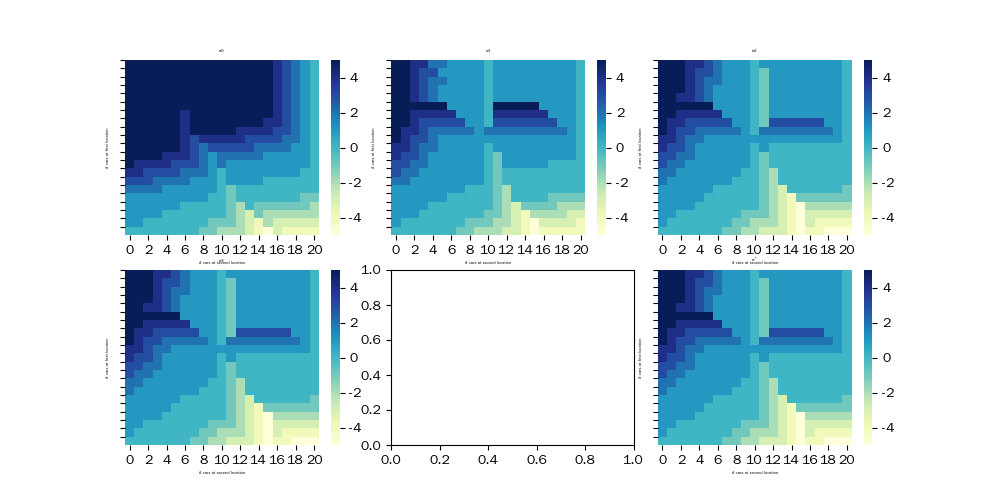

In [24]:
threshold=1e-4
gamma=0.9
v=np.zeros((21,21)) # 车库1×车库2
v_new=np.zeros((21,21))
policy=np.zeros((21,21),dtype=np.int32) # s=(),a=pi(s)

policy_stable=False
iter_num=0

_, axes = plt.subplots(2, 3, figsize=(10, 5))
# 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
plt.subplots_adjust(wspace=0.1, hspace=0.2)
# 这里将子图形成一个1*6的列表
axes = axes.flatten()
while (not policy_stable) and iter_num<20 :
    print(f"iter_num: {iter_num}")
    while True:
        ## 策略评估
        for car1 in range(21):
            for car2 in range(21):
                s1=car1-policy[car1,car2]
                s2=car2+policy[car1,car2]
                paking_fee=4*(s1>10)+4*(s2>10)
                p_snew=Ps1[s1,:].reshape((-1,1))@Ps2[s2,:].reshape((1,-1))
                if policy[car1,car2]>0:
                    action=policy[car1,car2]-1
                else:
                    action=policy[car1,car2]
                v_new[car1,car2]=-paking_fee-2*np.abs(action)+R_b1[s1]+R_b2[s2]+gamma*np.sum(p_snew*v)
        detal=np.max(np.abs(v_new-v))
        v=v_new.copy()
        if detal<threshold:break
    print("策略评估完成")
    policy_stable=True
    for car1 in range(21):
        for car2 in range(21):
            v_base=v[car1,car2]
            a_lower=-np.min((5,car2,20-car1))
            a_upper=np.min((5,car1,20-car2))
            for a in range(a_lower,a_upper+1):
                s1=car1-a
                s2=car2+a
                paking_fee=4*(s1>10)+4*(s2>10)
                p_snew=Ps1[s1,:].reshape((-1,1))@Ps2[s2,:].reshape((1,-1))
                action=a-1 if a>0 else a
                val=-paking_fee-2*np.abs(action)+R_b1[s1]+R_b2[s2]+gamma*np.sum(p_snew*v)
                if val>v_base+1e-4:
                    policy[car1,car2]=a
                    v_base=val
                    policy_stable=False
    print("策略改进完成")
    if iter_num<5:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iter_num])
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=3)
        fig.set_yticks(list(reversed(range(20 + 1))))
        fig.set_xlabel('# cars at second location', fontsize=3)
        fig.set_title('$\pi{}$'.format(iter_num), fontsize=3)
    iter_num+=1

fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-1])
# 定义标签与标题
fig.set_ylabel('# cars at first location', fontsize=3)
fig.set_yticks(list(reversed(range(20 + 1))))
fig.set_xlabel('# cars at second location', fontsize=3)
fig.set_title('$\pi^*$', fontsize=3)

## 赌徒

In [20]:
# 每一行用行数赋值
rowmat=np.array(
    [np.full((101,),k,dtype=np.int64) for k in range(101)],
    dtype=np.int64
)
# 每一列用行数赋值
colmat=rowmat.T
# 行是赌本（s），列是下注多少（action）
# 赢了之后的状态
s_lose=rowmat-colmat ## 输
s_win=rowmat+colmat ## 赢
# 合理的状态的位置
valid_index=(s_lose>=0)&(s_win<=100)
valid_index[-1,:]=False ## 100 终止
valid_index[:,0]=False ## 不下注v始终为0

# False等价于0，True等价于1
Rsa=(s_win==100)&(valid_index)
## 输了,\sum P(s'|s,a)v(s')=ph*v[idx2]+(1-ph)*v[idx1]
idx1=s_lose[valid_index]
## 赢了
idx2=s_win[valid_index]


In [45]:
# %matplotlib widget
%matplotlib ipympl
ph=0.40
threshold=1e-8

def gamble(ph=0.4):
    validR=ph*Rsa[valid_index]
    v=np.zeros((101,)) # 0,...,100
    v_new=np.zeros((101,))
    v_sa=np.zeros((101,101))
    policy=np.zeros((101,1))
    plt.close()
    _, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    iter_num=0
    while True:
        tmp=1*(ph*v[idx2]+(1-ph)*v[idx1])+validR
        v_sa[valid_index]=tmp
        v_new=v_sa.max(axis=1)
        if np.all(np.abs(v-v_new)<threshold):
            v=v_new
            break
        else:
            v=v_new
        if iter_num<4:
            axes[0].plot(range(1,100),v[1:-1],linewidth=0.2)
        iter_num+=1
    axes[0].plot(range(1,100),v[1:-1],linewidth=1)
    ## 相同收益优先下更少的注（为了复现书里的结果）
    # action=(v_sa>v_new.reshape((-1,1))-1e-6)
    # priority=np.array([1e-7-k*1e-8 for k in range(101)]).reshape((1,-1))
    # policy_1=np.argmax(v_sa+priority,axis=1)
    # fig=plt.figure()
    # ax=fig.add_subplot()
    # ax.scatter(range(1,100),policy_1[1:-1],label="策略1")
    # policy_2=np.argmax(v_sa-priority,axis=1)
    # ax.scatter(range(1,100),policy_2[1:-1],marker='.',linewidths=0.2,label="策略2")
    # ax.legend()
    # plt.show()

    tmp=(v_sa>v_new.reshape((-1,1))-threshold*10)
    tmp[[0,-1],:]=0
    funds,action=np.where(tmp)
    axes[1].scatter(funds,action,marker=".",linewidths=0.2,label="可行策略")
    # ax.legend()
    plt.legend()
    plt.show()


In [46]:
%matplotlib ipympl

w=interactive(gamble,ph=(0.1,1,0.01))
w

interactive(children=(FloatSlider(value=0.4, description='ph', max=1.0, min=0.1, step=0.01), Output()), _dom_c…